In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1

2023-04-25 21:00:43.602887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-04-25 21:00:51.216354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 21:00:51.311498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 21:00:51.311767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
learning_rate = 1e-6
num_dense_layers = 7
num_dense_nodes = 150
iterations = 20000
activation = 'tanh'
weights = 100

In [3]:
nx_train = 100
nx_test = 300

In [5]:
L = 1
m = 1
omega = 0.5
n_max = 2

In [6]:
def pde(x, y):
    n = x[:, 1:2]
    E = (n + 0.5) * omega
    U = 0.5 * m * (omega ** 2) * (x[:, 0:1] ** 2)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return -dy_xx / 2 + (U - E) * y

In [7]:
def psi(x):
    n = x[:, 1:2].astype(int)
    factorials = []
    for n_val in n:
        factorials.append(np.math.factorial(int(n_val)))
    factorials = np.array(factorials).reshape(len(factorials), 1)
    
    constants = (1.0 / (np.sqrt(factorials * 2 ** n))) * (((m * omega) / np.pi) ** 0.25)

    exponent = np.exp(-0.5 * m * omega * np.power(x[:, 0:1], 2))
    
    hermite_values = []
    for index, n_val in enumerate(n):
        coefficients = int(n_val) * [0] + [1]
        hermite = np.polynomial.hermite.Hermite(coefficients)
        hermite_value = hermite(x[index, 0] * np.sqrt(m * omega))
        hermite_values.append(hermite_value)
    hermite_values = np.array(hermite_values).reshape(len(hermite_values), 1)

    result = constants * exponent * hermite_values
    return result.astype(dde.config.real(np))

In [8]:
def get_collocation_points(n_max):
    points = []
    for n in range(0, n_max + 1):
        points.append((0.0, n))
    return np.array(points)

In [9]:
def psi_0(x):
    n = int(x[1])
    if n % 2 == 1:
        return 0
        
    normalization_constant = (1.0 / (np.sqrt(np.math.factorial(n) * 2 ** n))) * (((m * omega) / np.pi) ** 0.25)
    if n == 0:
        return normalization_constant
    
    hermite_coefficients = [0] * (n - 2) + [1]
    hermite = np.polynomial.hermite.Hermite(hermite_coefficients)
    hermite_value = hermite(0)
    
    return -normalization_constant * 2 * (n - 1) * hermite_value

In [10]:
def dpsi_0(x):
    n = int(x[1])
    if n % 2 == 0:
        return 0
    
    normalization_constant = (1.0 / (np.sqrt(np.math.factorial(n) * 2 ** n))) * (((m * omega) / np.pi) ** 0.25)
    constants = 2 * n * np.sqrt(m * omega) * normalization_constant
    
    hermite_coefficients = [0] * (n - 1) + [1]
    hermite = np.polynomial.hermite.Hermite(hermite_coefficients)
    hermite_value = hermite(0)
    
    return constants * hermite_value

In [11]:
def dpsi_network(x, y, X):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    return dy_x

In [12]:
domain = dde.geometry.Rectangle([-L, 0], [L, n_max])

In [13]:
collocation_points = get_collocation_points(n_max)
collocation_values = np.array([psi_0(x) for x in collocation_points])
collocation_values = collocation_values.reshape(collocation_values.shape + (1,))

derivative_values = np.array([dpsi_0(x) for x in collocation_points])
derivative_values = derivative_values.reshape(derivative_values.shape + (1,))

In [14]:
ic = dde.icbc.PointSetBC(collocation_points, collocation_values)
opic = dde.icbc.PointSetOperatorBC(collocation_points, derivative_values, dpsi_network)

In [15]:
def boundary(x, _):
    if x[1].is_integer():
        return np.isclose(x[0], -L) or np.isclose(x[0], L)
    return False

In [16]:
dirichlet_bc = dde.icbc.DirichletBC(domain, psi, boundary)

In [17]:
bcs = [ic, opic, dirichlet_bc]

In [18]:
data = dde.data.PDE(
    domain, 
    pde, 
    bcs, 
    num_domain=nx_train ** 2, 
    num_boundary=(n_max + 1) * 2,
    solution=psi, 
    num_test=nx_test ** 2
)

In [19]:
net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], 
    activation, 
    'Glorot uniform')

In [20]:
model = dde.Model(data, net)

loss_weights = [1, weights, weights, weights]
model.compile(
    'L-BFGS', 
    lr=learning_rate, 
    metrics=['l2 relative error'],
    loss_weights=loss_weights
)

Compiling model...
Building feed-forward neural network...
'build' took 0.159549 s



/home/piotr/repos/quant-chem-pinns/venv/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-04-25 21:01:42.865053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 21:01:42.865362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 21:01:42.865597: I tensorflow/compiler/x

'compile' took 2.321990 s



In [21]:
loss_history, train_state = model.train(iterations=iterations)

Initializing variables...
Training model...



2023-04-25 21:01:47.687499: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-04-25 21:01:47.885829: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fd718005230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-25 21:01:47.885868: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce 940MX, Compute Capability 5.0
2023-04-25 21:01:47.902354: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-25 21:01:50.163674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-04-25 21:01:53.249809: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                  Test loss                                   Test metric   
0         [2.28e-03, 1.88e+01, 2.09e+01, 2.65e+01]    [2.27e-03, 1.88e+01, 2.09e+01, 2.65e+01]    [1.08e+00]    
1000      [3.12e-02, 9.75e+00, 9.82e+00, 2.86e+00]    [3.11e-02, 9.75e+00, 9.82e+00, 2.86e+00]    [9.85e-01]    
2000      [3.52e-02, 5.08e+00, 1.00e+01, 2.06e+00]    [3.50e-02, 5.08e+00, 1.00e+01, 2.06e+00]    [8.85e-01]    
3000      [4.05e-02, 1.69e+00, 1.00e+01, 1.78e+00]    [4.02e-02, 1.69e+00, 1.00e+01, 1.78e+00]    [7.84e-01]    
4000      [4.59e-02, 3.40e-01, 9.87e+00, 1.84e+00]    [4.56e-02, 3.40e-01, 9.87e+00, 1.84e+00]    [7.26e-01]    
5000      [4.78e-02, 1.13e-01, 9.56e+00, 1.77e+00]    [4.76e-02, 1.13e-01, 9.56e+00, 1.77e+00]    [7.18e-01]    
6000      [5.03e-02, 4.53e-02, 8.93e+00, 1.50e+00]    [5.01e-02, 4.53e-02, 8.93e+00, 1.50e+00]    [7.25e-01]    
7000      [7.25e-02, 1.22e-02, 6.71e+00, 6.66e-01]    [7.22e-02, 1.22e-02, 6.71e+00, 6.66e-01]  

Saving loss history to /home/piotr/repos/quant-chem-pinns/loss.dat ...
Saving training data to /home/piotr/repos/quant-chem-pinns/train.dat ...
Saving test data to /home/piotr/repos/quant-chem-pinns/test.dat ...


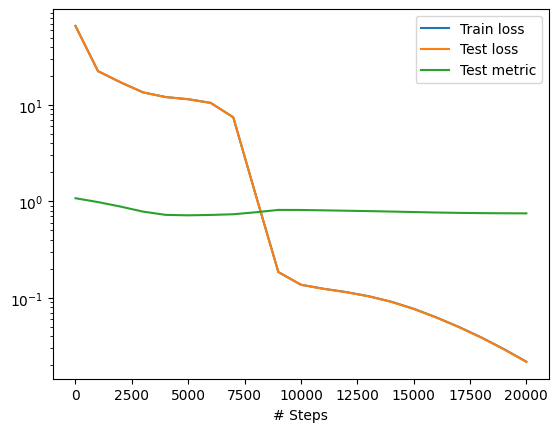

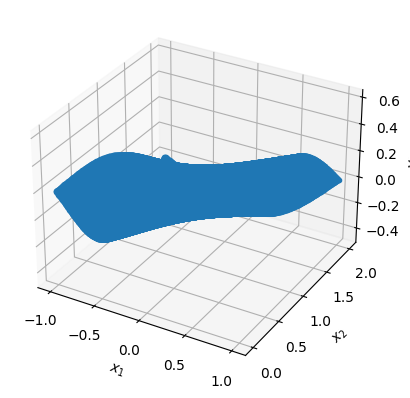

In [22]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

In [23]:
model.predict([[0.0, 0.0]])

array([[0.63159037]], dtype=float32)

In [24]:
def predict_for_n(points):
    prediction = model.predict(points)
    return np.array(prediction)

In [25]:
def plot_results_for_n(n, num_points=10):
    x = np.linspace(-L, L, num=num_points)
    points = np.array([[i, n] for i in x])
    predictions = predict_for_n(points)
    true_values = psi(points)
    
    fig, ax = plt.subplots()
    ax.plot(x, predictions, 'bo', label='predicted')
    ax.plot(x, true_values, '--', label='true')
    fig.legend()

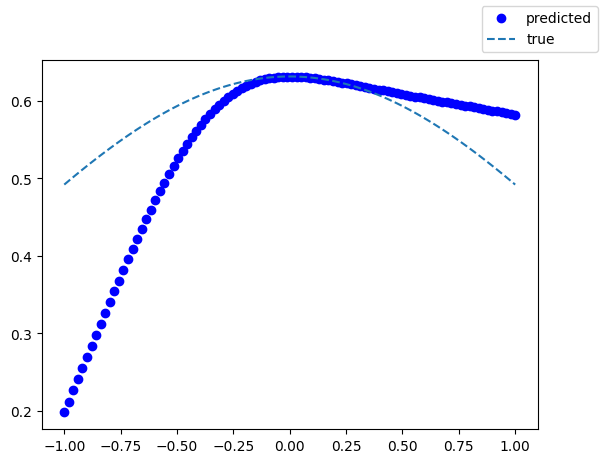

In [31]:
plot_results_for_n(0, 100)

In [ ]:
psi_0([0, 0])

In [ ]:
psi(np.array([[-2, 0]]))